In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load all CSVs (in real case, it will be multiple csv files too)
data_dir = Path('chaos_dataset')
csv_files = list(data_dir.glob('*.csv'))

for file in csv_files:
    print(f"  - {file.name}")

# Load and merge
all_data = []

for file in csv_files:
    df = pd.read_csv(file)
    all_data.append(df)

# Combine all dataframes
merged_data = pd.concat(all_data, ignore_index=True)
print(f"Total merged dataset: {len(merged_data)} rows")
print(f"Columns: {list(merged_data.columns)}")

  - argentina_dream_study_month5.csv
  - argentina_dream_study_month2.csv
  - usa_dream_study_month1.csv
  - usa_dream_study_month2.csv
  - usa_dream_study_month4.csv
  - argentina_dream_study_month1.csv
  - argentina_dream_study_month4.csv
  - argentina_dream_study_month3.csv
  - usa_dream_study_month5.csv
  - usa_dream_study_month3.csv
Total merged dataset: 2050 rows
Columns: ['ParticipantID', 'Timepoint', 'Country', 'StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'InformedConsent', 'Demo_Age', 'Demo_Education', 'Demo_Student', 'Demo_Gender', 'GAD_Bothered_1', 'GAD_Bothered_2', 'GAD_Bothered_3', 'GAD_Bothered_4', 'GAD_Bothered_5', 'GAD_Bothered_6', 'GAD_Bothered_7', 'GAD_DifficultWork_1', 'PHQ_Bothered_1', 'PHQ_Bothered_2', 'PHQ_Bothered_3', 'PHQ_B

In [3]:
merged_data['Dream_Feelings'].unique()

array(['Very negative', 'Somewhat negative', 'Neutral',
       'Somewhat positive', 'Very positive'], dtype=object)

In [4]:
merged_data['Dream_Feelings'].value_counts(dropna=False)

Dream_Feelings
Somewhat negative    766
Very negative        671
Neutral              484
Somewhat positive    121
Very positive          8
Name: count, dtype: int64

In [5]:
def classify_feelings(feeling):
    if pd.isna(feeling):
        return 'missing'
    feeling = str(feeling).lower()

    if 'very negative' in feeling:
        return 'nightmare'
    elif 'somewhat negative' in feeling:
        return 'bad_dream'
    elif 'neutral' in feeling:
        return 'neutral'
    else:
        return 'positive'

merged_data['DreamType'] = merged_data['Dream_Feelings'].apply(classify_feelings)
merged_data['DreamType'].value_counts()

DreamType
bad_dream    766
nightmare    671
neutral      484
positive     129
Name: count, dtype: int64

In [6]:
# Filter for neutral vs nightmare
subset_df = merged_data[merged_data['DreamType'].isin(['nightmare', 'neutral'])]

subset_df.head(3)

,ParticipantID,Timepoint,Country,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,...,More_CoffeeTime,More_Stimulants,More_AlcoholFreq,More_AlcoholAmount,More_Cigarettes,More_LivingSituation,More_Pets,ProlificID,PROLIFIC_PID,DreamType
0,P0000,5,Argentina,2024-07-17 16:31:00,2024-07-17 16:50:03,IP Address,192.168.226.187,100,1143,True,...,After 6pm,No,2-4 times a month,3-4 drinks,Daily,With partner and children,No,P3540808989,P3540808989,nightmare
3,P0003,5,Argentina,2024-07-26 17:46:00,2024-07-26 17:56:48,IP Address,192.168.185.60,100,648,True,...,Before noon,Yes,Never,NaN,No,Living with partner/family,No,P1949456961,P1949456961,neutral
4,P0004,5,Argentina,2024-07-22 19:25:00,2024-07-22 19:43:25,IP Address,192.168.4.207,100,1105,True,...,12-3pm,No,Monthly or less,5-6 drinks,Yes,With partner and children,No,P4804937484,P4804937484,nightmare


In [8]:
import networkx as nx
from nltk.tokenize import word_tokenize

def analyze_dream_graph(text):
    # Handle empty or missing dreams
    if pd.isna(text) or not str(text).strip():
        return pd.Series({
            'num_nodes': np.nan,
            'num_edges': np.nan,
            'avg_degree': np.nan,
            'largest_cc': np.nan,
            'diameter': np.nan
        })

    # Tokenize and clean
    tokens = [w.lower() for w in word_tokenize(str(text)) if w.isalpha()]

    # Build edges and graph
    edges = list(zip(tokens[:-1], tokens[1:]))
    G = nx.Graph()
    G.add_edges_from(edges)

    # Compute metrics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes if num_nodes > 0 else 0
    largest_cc = max((len(c) for c in nx.connected_components(G)), default=0)
    diameter = nx.diameter(G) if nx.is_connected(G) else np.nan

    return pd.Series({
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'avg_degree': avg_degree,
        'largest_cc': largest_cc,
        'diameter': diameter
    })


In [9]:
df_graphs = merged_data[['ParticipantID', 'DreamMemory']].copy()
graph_metrics = df_graphs['DreamMemory'].apply(analyze_dream_graph)
df_graphs = pd.concat([df_graphs, graph_metrics], axis=1)

In [10]:
merged = merged_data.merge(df_graphs, on='ParticipantID')

<Axes: xlabel='DreamType', ylabel='largest_cc'>

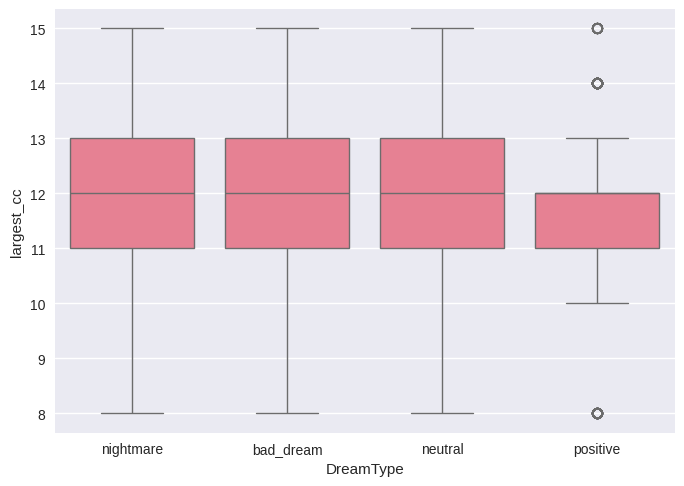

In [11]:
sns.boxplot(x='DreamType', y='largest_cc', data=merged)

<Axes: xlabel='DreamType', ylabel='diameter'>

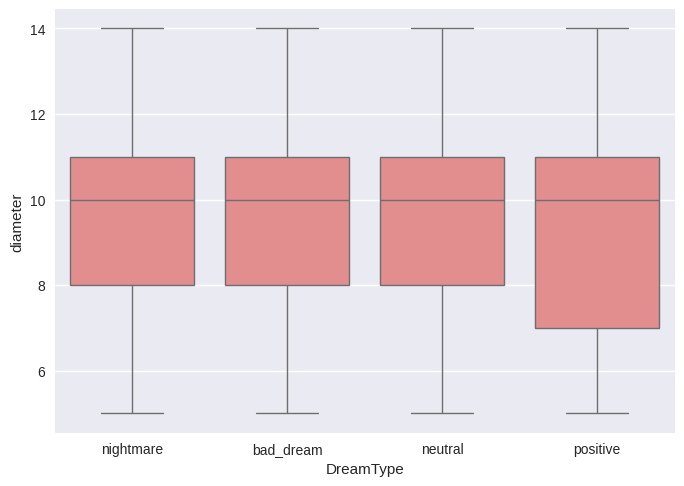

In [12]:
sns.boxplot(x='DreamType', y='diameter', data=merged, color='lightcoral')